In [17]:
import scib 
import scanpy as sc
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [19]:
# the following function expects an embedding output; X_emb
# can of course be adjusted so that it takes all integration outputs as input 
def compute_metrics_after(adata_pre, adata_post, label_key,batch_key, integration_method):
    results = scib.metrics.metrics(adata_pre, adata_post, batch_key, label_key, embed='X_emb', cluster_key='cluster',
                     ari_=True, nmi_=True,silhouette_=True, pcr_=True,graph_conn_=True,kBET_=True, lisi_graph_=True,   
                     type_="emb")
    
    # compute only the principal component regression score without the comparison: 
    pcr = scib.me.pcr(adata_post, covariate=batch_key, embed="X_emb")
    #append pcr to results: 
    results.loc["PCR_NC"] = pcr
    # remove rows containing NaNs for metrics that weren't computed
    results = results.drop(["cell_cycle_conservation", "isolated_label_F1", "isolated_label_silhouette",
                           "hvg_overlap", "trajectory"])
    #change row names: 
    results = results.rename({"graph_conn": "Graph_Conn", "PCR_batch": "PCR_Comparison", "ASW_label/batch": "Silhouette_batch",
                             "ASW_label": "Silhouette", "NMI_cluster/label": "NMI", "ARI_cluster/label": "ARI"}, axis='index')
    #change column name 
    results = results.rename(columns={0: integration_method})
    
    return results

# RxRx1: scIB, Metrics and Integration

* [I. Before integration](#before) 
    * [A. Reminder: What do we want to correct for?](#before1) 
    * [B. Which metrics do we want to compute for this dataset?](#before2) 
    * [C. Computing scIB metrics](#before3) 
* [II. Integration](#integration) 
    * [A. Harmony](#integration1)
* [III. After integration](#after) 
    * [A. Compute scIB metrics](#after1)
    * [B. Visualize integrated data with UMAPs](#after2)

## I. Before integration  <a class="anchor" id="before"></a>

<font size="3"> **<u> A.  Reminder: What do we want to correct for?</u>** </font> <a class="anchor" id="before1"></a>

Read in the data: 

In [3]:
adata = sc.read_h5ad("/home/sarah/Downloads/Masterpraktikum/data_exploration/rxrx1_huvec.h5ad")
adata

AnnData object with n_obs × n_vars = 5982 × 128
    obs: 'well_id', 'cell_type', 'dataset', 'experiment', 'plate', 'well', 'site', 'well_type', 'sirna', 'sirna_id', 'well_row', 'well_column'

In the dataset, we have the 30 different positive controls and the negative control of the HUVEC cell line across 24 experiments. 

Regarding the batch effect, the data clusters overall by siRNA: 

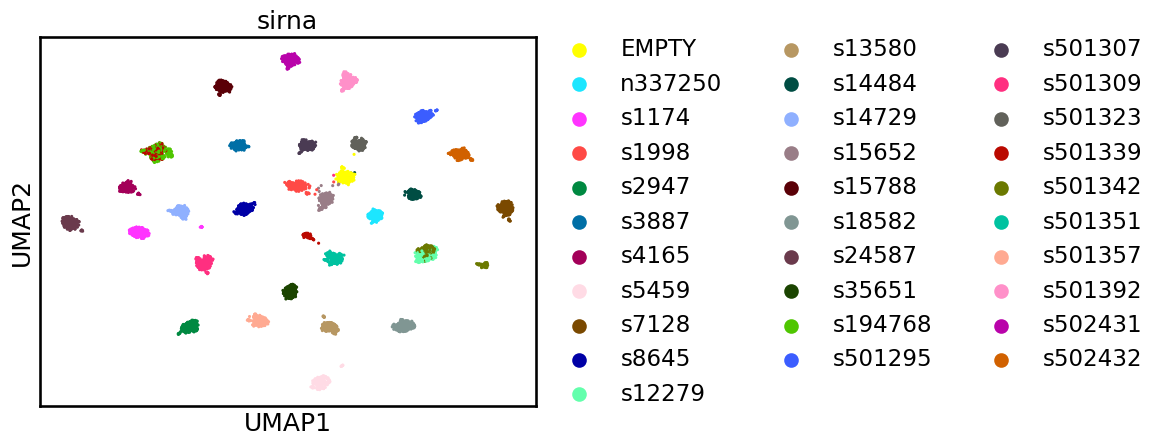

In [4]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep = "X")
sc.tl.umap(adata)
sc.pl.umap(adata, color= "sirna")

But when looking at only one siRNA, we can see some clustering by experiment: 

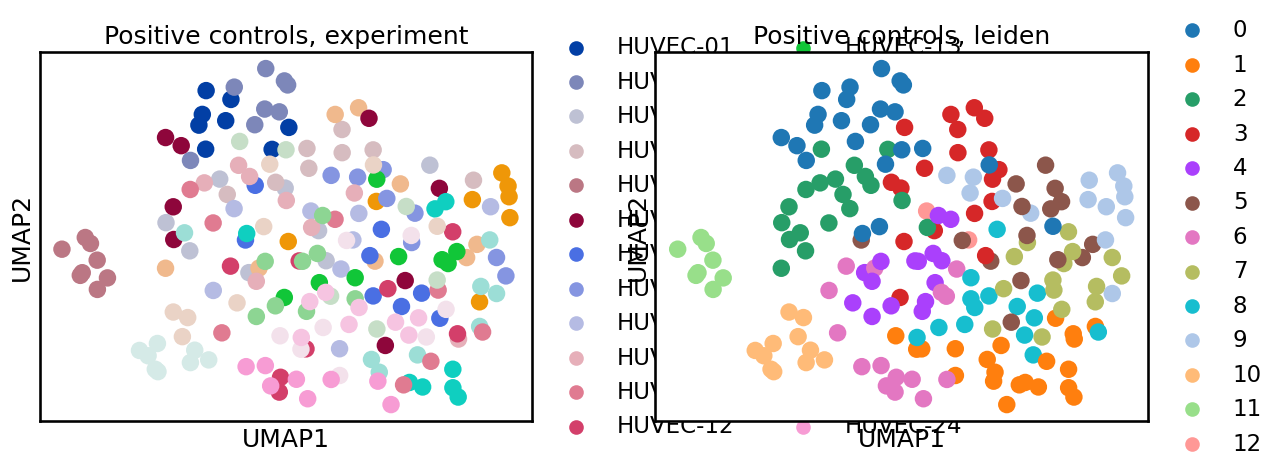

In [5]:
poscontrols_sirna = adata[adata.obs["sirna"] == "s501351"]
sc.pp.neighbors(poscontrols_sirna, n_neighbors=15, use_rep = "X")
sc.tl.umap(poscontrols_sirna)
sc.tl.leiden(poscontrols_sirna, resolution = 1.5)
sc.pl.umap(poscontrols_sirna, color=["experiment", "leiden"], title = ["Positive controls, experiment", "Positive controls, leiden"])

**The batch variable we want to correct for is therefore the experiment.**

<font size="3"> **<u> B. Which metrics do we want to compute for this dataset?</u>** </font> <a class="anchor" id="before2"></a>

Metrics we **exclude** for this dataset: 

    - Cell Cycle Conservation score
    - HVG Overlap 
    - Trajectory Conservation 
    - Isolated Label score 
    
We exclude the CCC, HVG Overlap and Trajectory Conservation score for this dataset, because those metrics are specifically designed for gene expression data. <br>
The isolated label score is not considered for this dataset, because in each batch, i.e. experiment, we have all labels. There is no label that is present in a lower number of batches. 

The computed metrics are therefore: 

    - Graph connectivity score 
    - iLISI
    - kBET
    - PCR
    - Silhouette batch 
for quantifying the removal of batch effects. Regarding the PCR: this score is computed after integration once with the comparison (scib.metrics.pcr_comparison()) and once without the comparison (scib.metrics.pcr()). <br>
The following biological conservation metrics are calculated: 
    
    - cLISI
    - Silhouette
    - NMI 
    - ARI 

<font size="3"> **<u> C.  Computing scIB metrics</u>** </font> <a class="anchor" id="before3"></a>

Let's compute the scIB metrics for the unintegrated data: 

**Batch effect metrics:** 

In [6]:
#graph connectivity
#expects anndata with computed neighborhood graph as input: 
sc.pp.neighbors(adata, n_neighbors=15, use_rep = "X")
gc = scib.me.graph_connectivity(adata, label_key="sirna")
#ilisi
# in case of embedding: computes neighborhood graph on embedding
# when type = "full", PCA computed if not present + pp.neighbors run with default parameters (PCA if #features > 50)
# when type = "knn": pp.neighbors not computed! 
# we want to use all 128 features of X for the neighborhood graph and not the PCs!
# --> specify type as "knn"
# see also: https://github.com/theislab/scib/blob/main/scib/metrics/lisi.py
ilisi = scib.me.ilisi_graph(adata, batch_key="experiment", type_="knn")
#kbet
# similar as above, specify as "knn"
# see: https://github.com/theislab/scib/blob/main/scib/metrics/kbet.py
kbet = scib.me.kBET(adata, batch_key="experiment", label_key="sirna", type_="knn")
#principal component regression, computes PCA if not provided: 
pcr_nc = scib.me.pcr(adata, covariate="experiment")
#silhouette batch 
#only takes a slot in .obsm as input, i.e. embedding or pca 
# --> compute PCA 
sc.pp.pca(adata, n_comps = 100)
silhouette_batch = scib.me.silhouette_batch(adata, batch_key="experiment", label_key="sirna", embed="X_pca")

Adding diffusion to step 2
mean silhouette per group:          silhouette_score
group                    
EMPTY            0.946376
n337250          0.949521
s1174            0.919468
s12279           0.952156
s13580           0.935684
s14484           0.950601
s14729           0.929182
s15652           0.947399
s15788           0.936380
s18582           0.934917
s194768          0.930625
s1998            0.934751
s24587           0.933310
s2947            0.926234
s35651           0.940658
s3887            0.941196
s4165            0.935314
s501295          0.926037
s501307          0.940157
s501309          0.939060
s501323          0.934219
s501339          0.928687
s501342          0.951715
s501351          0.933239
s501357          0.942363
s501392          0.933964
s502431          0.941904
s502432          0.927447
s5459            0.915119
s7128            0.937480
s8645            0.938113


**Biological Conservation Metrics**

In [7]:
#cell type lisi
# same as for ilisi score -> specify it as "knn"
clisi = scib.me.clisi_graph(adata, label_key="sirna", type_="knn")
#silhouette
# same as for silhouette batch 
silhouette = scib.me.silhouette(adata, label_key="sirna", embed="X_pca")
#NMI and ARI 
# cluster_optimal_resolution uses precomputed knn if use_rep == None
nmi = scib.metrics.cluster_optimal_resolution(adata, label_key = "sirna",cluster_key = "cluster", metric = scib.me.nmi, return_all = True)[1]
ari = scib.metrics.cluster_optimal_resolution(adata, label_key = "sirna",cluster_key = "cluster", metric = scib.me.ari, return_all = True)[1]

resolution: 0.1, nmi: 0.9533174731650924
resolution: 0.2, nmi: 0.9733977306272006
resolution: 0.3, nmi: 0.9793501955109899
resolution: 0.4, nmi: 0.9793501955109897
resolution: 0.5, nmi: 0.9793501955109899
resolution: 0.6, nmi: 0.9785536138128551
resolution: 0.7, nmi: 0.9777583269052897
resolution: 0.8, nmi: 0.9777583269052897
resolution: 0.9, nmi: 0.9777583269052897
resolution: 1.0, nmi: 0.9777665415996725
resolution: 1.1, nmi: 0.9777665415996725
resolution: 1.2, nmi: 0.9777665415996725
resolution: 1.3, nmi: 0.9777665415996725
resolution: 1.4, nmi: 0.9777665415996725
resolution: 1.5, nmi: 0.9777665415996725
resolution: 1.6, nmi: 0.9777665415996725
resolution: 1.7, nmi: 0.9777665415996725
resolution: 1.8, nmi: 0.9777665415996725
resolution: 1.9, nmi: 0.9777665415996725
resolution: 2.0, nmi: 0.9777665415996725
optimised clustering against sirna
optimal cluster resolution: 0.3
optimal score: 0.9793501955109899
resolution: 0.1, ari: 0.8097722151037117
resolution: 0.2, ari: 0.90893348660052

Putting all of it together: 

In [8]:
unintegrated_metrics = pd.DataFrame({"Unintegrated": []})
unintegrated_metrics.loc["Graph_Conn"] = gc
unintegrated_metrics.loc["iLISI"] = ilisi
unintegrated_metrics.loc["PCR_NC"] = pcr_nc
unintegrated_metrics.loc["PCR_Comparison"] = None
unintegrated_metrics.loc["kBET"] = kbet
unintegrated_metrics.loc["Silhouette_batch"] = silhouette_batch
unintegrated_metrics.loc["cLISI"] = clisi
unintegrated_metrics.loc["Silhouette"] = silhouette
unintegrated_metrics.loc["NMI"] = nmi
unintegrated_metrics.loc["ARI"] = ari
unintegrated_metrics

,Unintegrated
Graph_Conn,0.990084
iLISI,0.340054
PCR_NC,0.003847
PCR_Comparison,NaN
kBET,0.405613
Silhouette_batch,0.936557
cLISI,0.999896
Silhouette,0.629706
NMI,0.979350
ARI,0.935945


## II. Integration  <a class="anchor" id="integration"></a>

<font size="3"> **<u> A.  Harmony</u>** </font> <a class="anchor" id="integration1"></a>

In [9]:
harmony = adata.copy()
scib.integration.harmony(harmony, batch = "experiment")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).


AnnData object with n_obs × n_vars = 5982 × 128
    obs: 'well_id', 'cell_type', 'dataset', 'experiment', 'plate', 'well', 'site', 'well_type', 'sirna', 'sirna_id', 'well_row', 'well_column', 'cluster'
    uns: 'neighbors', 'umap', 'sirna_colors', 'pca', 'leiden'
    obsm: 'X_umap', 'X_pca', 'X_emb'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## III. After integration  <a class="anchor" id="after"></a>

<font size="3"> **<u> A.  Compute scib metrics</u>** </font> <a class="anchor" id="after1"></a>

<u> Harmony </u> 

In [21]:
harmony_metrics = compute_metrics_after(adata, harmony, "sirna", "experiment", "Harmony") 

NMI...
ARI...
Silhouette score...
PC regression...
Graph connectivity...
kBET...


/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warni

/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warni

/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warni

/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sarah/anaconda3/envs/masterpraktikum/envs/masterpraktikum/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warni

cLISI score...
Chunk 62 does not have enough neighbors. Skipping...
Chunk 186 does not have enough neighbors. Skipping...
Chunk 300 does not have enough neighbors. Skipping...
Chunk 349 does not have enough neighbors. Skipping...
Chunk 350 does not have enough neighbors. Skipping...
Chunk 426 does not have enough neighbors. Skipping...
Chunk 515 does not have enough neighbors. Skipping...
Chunk 516 does not have enough neighbors. Skipping...
Chunk 587 does not have enough neighbors. Skipping...
Chunk 588 does not have enough neighbors. Skipping...
Chunk 623 does not have enough neighbors. Skipping...
Chunk 624 does not have enough neighbors. Skipping...
Chunk 874 does not have enough neighbors. Skipping...
Chunk 942 does not have enough neighbors. Skipping...
Chunk 1037 does not have enough neighbors. Skipping...
Chunk 1038 does not have enough neighbors. Skipping...
Chunk 1095 does not have enough neighbors. Skipping...
Chunk 1096 does not have enough neighbors. Skipping...
Chunk 1209

<u> Putting it together: </u>

In [11]:
pd.merge(unintegrated_metrics, harmony_metrics, left_index=True, right_index=True)

,Unintegrated,Harmony
Graph_Conn,0.990084,0.990084
iLISI,0.340054,0.340109
PCR_NC,0.003847,0.000945
PCR_Comparison,NaN,0.754349
kBET,0.405613,0.959135
Silhouette_batch,0.936557,0.883292
cLISI,0.999896,0.999894
Silhouette,0.629706,0.680406
NMI,0.979350,0.979396
ARI,0.935945,0.936188


Except for the Silhouette batch score, all scores are equal or better for the integrated data. 

<font size="3"> **<u> B.  Visualize integrated data with UMAPs</u>** </font> <a class="anchor" id="after2"></a>

<u> Harmony </u>

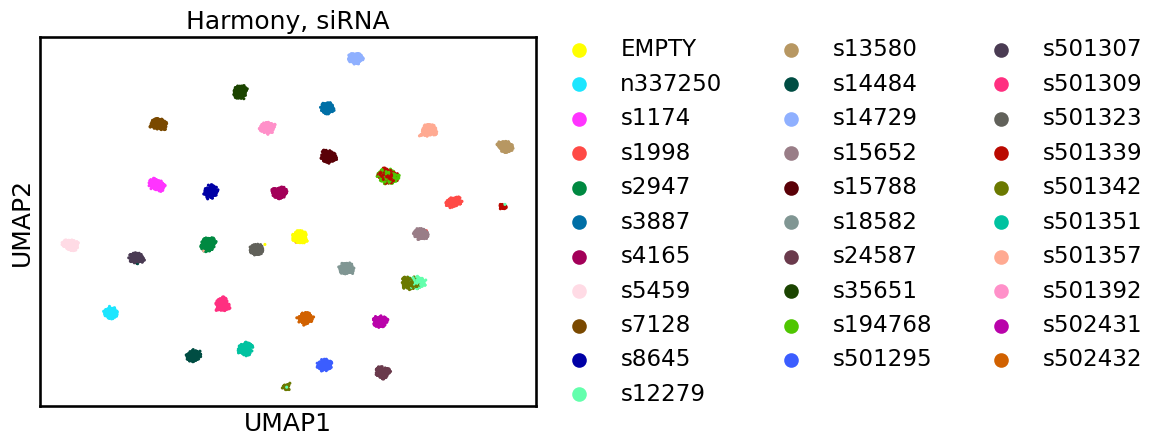

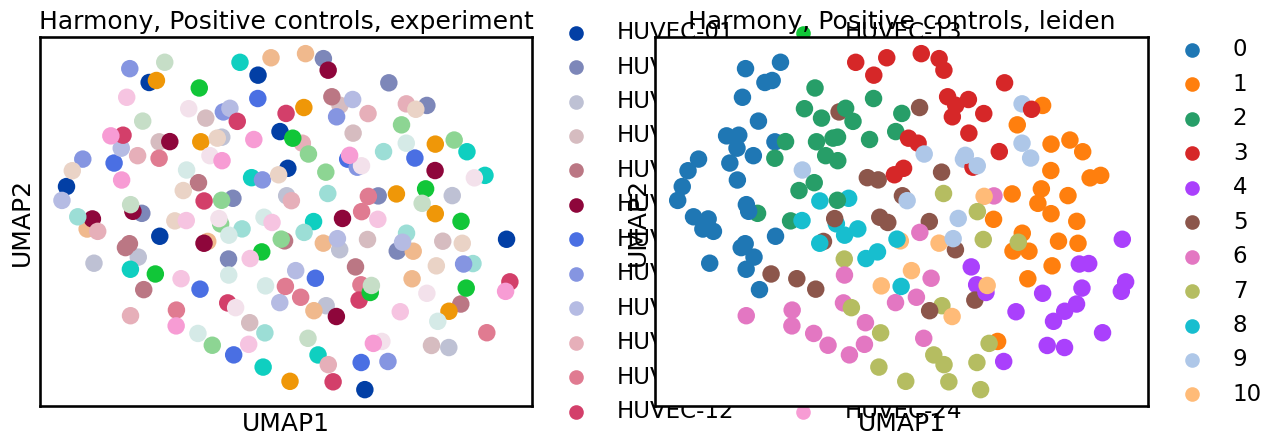

In [14]:
sc.pp.neighbors(harmony, n_neighbors=15, use_rep = "X_emb")
sc.tl.umap(harmony)
sc.pl.umap(harmony, color= "sirna", title = "Harmony, siRNA")
poscontrols_sirna = harmony[harmony.obs["sirna"] == "s501351"]
sc.pp.neighbors(poscontrols_sirna, n_neighbors=15, use_rep = "X_emb")
sc.tl.umap(poscontrols_sirna)
sc.tl.leiden(poscontrols_sirna, resolution = 1.5)
sc.pl.umap(poscontrols_sirna, color=["experiment", "leiden"], title = ["Harmony, Positive controls, experiment", "Harmony, Positive controls, leiden"])

After integration we can see that the data overall still clusters by siRNA. When subsetting on one siRNA, a clustering by experiment can't be observed anymore. 